In [1]:
# Remove input cells at runtime (nbsphinx)
import IPython.core.display as d
d.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# Comparison with EventDisplay

**Purpose of this notebook:**

- Read DL2 files from _EventDisplay_ in FITS format

- Read _pyirf_ output

- Compare the outputs

**Notes:**

The following results correspond to:

- Paranal site
- Zd 20 deg, Az 180 deg
- 50 h observation time

**Resources:**

_EventDisplay_ DL2 data, https://forge.in2p3.fr/projects/cta_analysis-and-simulations/wiki/Eventdisplay_Prod3b_DL2_Lists

**TO-DOs:**

- ...

## Table of contents

* [IRFs](#IRFs)
    - [Effective area](#Effective-area)
    - [Angular resolution](#Angular-resolution)
    - [Energy resolution](#Energy-resolution)
    - [Background rate](#Background-rate)
* [Differential sensitivity](#Differential-sensitivity)

## Imports

In [2]:
import numpy as np
import uproot
from astropy.io import fits
import matplotlib.pyplot as plt

In [3]:
import astropy.units as u
from astropy.coordinates import Angle
from gammapy.maps import MapAxis
from gammapy.irf import EffectiveAreaTable2D, EnergyDispersion2D, BgRateTable

## Definitions of classes and functions

If judged useful, these should be moved to pyirf!

## Input data

### _EventDisplay_

The input data provided by _EventDisplay_ is stored in _ROOT_ format, so _uproot_ is used to transform it into _numpy_ objects. 

In [4]:
# Path of the required input data in the user's local setup
# Please, empty these variables before pushing to the repo!
indir_EventDisplay = "/Users/michele/Applications/ctasoft/tests/pyirf/EventDisplay/IRFs/data/WPPhys201890925LongObs"
infile_EventDisplay = "DESY.d20180113.V3.ID0_180degNIM2LST4MST4SST4SCMST4.prod3b-paranal20degs05b-NN.S.3HB9-FD.180000s.root"

input_EventDisplay = uproot.open(f'{indir_EventDisplay}/{infile_EventDisplay}')

In [ ]:
# Contents of the ROOT file
# input_EventDisplay.keys()

### Setup of output data

## _pyirf_

The following is the current IRF + sensititivy output FITS format provided by this software.

In [5]:
indir_pyirf = "/Users/michele/Applications/ctasoft/tests/pyirf/EventDisplay/from_pyirf/irf_EventDisplay_Time50h/"
infile_pyirf = "irf.fits.gz"

hdul_pyirf = fits.open(f'{indir_pyirf}/{infile_pyirf}') # will be closed at the end of the notebook

# Contents of the FITS file
hdul_pyirf.info()

Filename: /Users/michele/Applications/ctasoft/tests/pyirf/EventDisplay/from_pyirf/irf_EventDisplay_Time50h//irf.fits.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       5   (100,)   float64   
  1  EFFECTIVE AREA    1 BinTableHDU     31   1R x 5C   [42D, 42D, 2D, 2D, 84D]   
  2  POINT SPREAD FUNCTION    1 BinTableHDU     18   21R x 3C   [E, E, E]   
  3  ENERGY DISPERSION    1 BinTableHDU     37   1R x 7C   [60D, 60D, 300D, 300D, 2D, 2D, 36000D]   
  4  BACKGROUND    1 BinTableHDU     18   21R x 3C   [E, E, E]   
  5  EFFECTIVE AREA    1 BinTableHDU     31   1R x 5C   [42D, 42D, 2D, 2D, 84D]   
  6  EFFECTIVE AREA    1 BinTableHDU     31   1R x 5C   [42D, 42D, 2D, 2D, 84D]   
  7  EFFECTIVE AREA    1 BinTableHDU     31   1R x 5C   [42D, 42D, 2D, 2D, 84D]   
  8  SENSITIVITY    1 BinTableHDU     22   21R x 5C   [E, E, E, E, E]   


### Setup of output data

It is possible to extract data from pyirf FITS file with different approaches, e.g.

- using *gammapy*, by reading the file HDUs into the appropriate IRF class like `EffectiveAreaTable2D` or `EnergyDispersion2D`
- opening the FITS file manually and reading data through the *astropy.fits* module as e.g. `BinTableHDU`

The *gammapy* solution seems to be cleaner, but it means that we depend on this specific science tool for plotting. This is not bad per-se, but we could need a more elastic approach for now, given that e.g. we do not yet work on full-enclosure IRFs and the offset handling in *gammapy* is hard-coded in its plotting methods.

To produce the following plots I use a mix of these two approaches as example, but it is possible to open and plot data by using consistently each of the two.

In [6]:
# Effective area

# Approach using gammapy

#aeff2D = EffectiveAreaTable2D.read(f'{indir_pyirf}/{infile_pyirf}', hdu=1)
#print(aeff2D)
#aeff=aeff2D.to_effective_area_table(offset=Angle('1d'), energy=energy * u.TeV)
#aeff.plot()
#plt.grid(which="both")
#plt.yscale("log")

# Manual approach
aeff_pyirf = hdul_pyirf[1]

aeff_pyirf_ENERG_LO = aeff_pyirf.data[0][0]
aeff_pyirf_EFFAREA  = aeff_pyirf.data[0][4][1]*1.e4 # there seems to be a 10**4 missing...maybe a bug in pyirf?

In [7]:
# Angular resolution

# At the moment the format provided by pyirf is not compatible with GADF
# https://gamma-astro-data-formats.readthedocs.io/en/latest/irfs/full_enclosure/psf/index.html

psf_pyirf = hdul_pyirf[2]

In [8]:
# Energy dispersion

# here I open manually, but I use gammapy.irf.EnergyDispersion2D to get the energy resolution

eDisp_pyirf = hdul_pyirf[3]

eDisp_pyirf_ENERG_LO = eDisp_pyirf.data[0][0]
eDisp_pyirf_ENERG_HI = eDisp_pyirf.data[0][1]

edisp2d_pyirf = EnergyDispersion2D.read(f'{indir_pyirf}/{infile_pyirf}', hdu="ENERGY DISPERSION")
edisp_pyirf = edisp2d_pyirf.to_energy_dispersion(offset=Angle('1d'), e_reco=eDisp_pyirf_ENERG_LO * u.TeV, e_true=eDisp_pyirf_ENERG_LO * u.TeV)

edisp_true_pyirf = np.asarray([(eDisp_pyirf_ENERG_HI[i]-eDisp_pyirf_ENERG_LO[i])/2. for i in range(len(eDisp_pyirf_ENERG_LO))])

resolution_pyirf = []
for e_true in edisp_true_pyirf:
    resolution_pyirf.append(edisp_pyirf.get_resolution(e_true * u.TeV))
resolution_pyirf = np.asarray(resolution_pyirf)

/Users/michele/Applications/anaconda3/envs/pyirf/lib/python3.7/site-packages/astropy/units/quantity.py:464: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


In [9]:
# Background rate

background_pyirf = hdul_pyirf[4]

In [10]:
# Differential sensitivity

sensitivity_pyirf = hdul_pyirf[8]

## Comparison

For the moment we do not require to replicate perfectly the EventDisplay output, because this depends also on:

- the configuration in config.yaml,
- the specific cuts optiization performed by EventDisplay (which has not yet been replicated in pyirf)

This comparison is here to make sure that we can produce a reliable and stable output and use it to proceed with the development.

A more detailed and complete version of this notebook will be provided with an official DL3 benchmarking.

### IRFs
[back to top](#Table-of-contents)

#### Effective area
[back to top](#Table-of-contents)

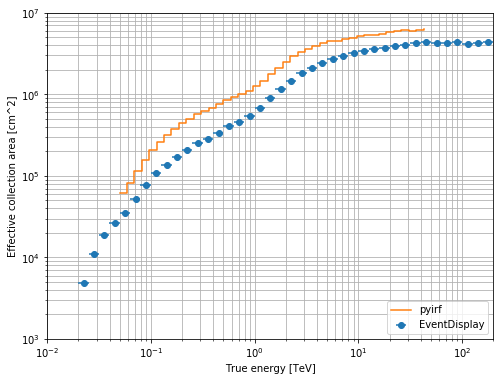

In [11]:
zoom = 2
plt.figure(figsize=(zoom*4,zoom*3))

# Data from EventDisplay
h = input_EventDisplay["EffectiveAreaEtrue"]
x = np.asarray([(10**x_bin[1]+10**x_bin[0])/2. for x_bin in h.allbins[3:-1]])
xerr = np.asarray([(10**x_bin[1]-10**x_bin[0])/2 for x_bin in h.allbins[3:-1]])
y = h.allvalues[3:-1]
yerr = h.allvariances[3:-1]

# Style settings
plt.xlim(1.e-2, 2.e2)
plt.ylim(1.e3, 1.e7)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("True energy [TeV]")
plt.ylabel("Effective collection area [cm^2]")
plt.grid(which="both")

# Plot function
plt.errorbar(x, y, xerr=xerr, yerr=None, fmt="o", label="EventDisplay")
plt.loglog(aeff_pyirf_ENERG_LO, aeff_pyirf_EFFAREA, drawstyle='steps-post', label="pyirf")

plt.legend(loc=4)
plt.show()

#### Angular resolution
[back to top](#Table-of-contents)

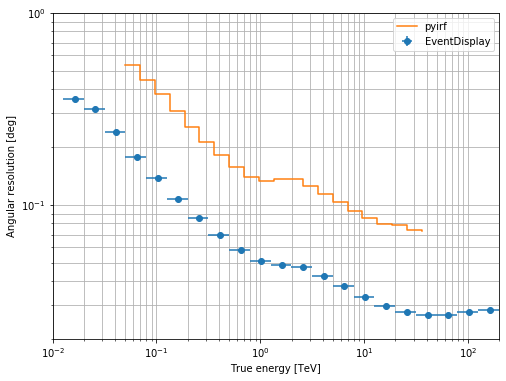

In [13]:
zoom = 2
plt.figure(figsize=(zoom*4,zoom*3))

# Data from EventDisplay
h = input_EventDisplay["AngRes"]
x = np.asarray([(10**x_bin[1]+10**x_bin[0])/2. for x_bin in h.bins])
xerr = np.asarray([(10**x_bin[1]-10**x_bin[0])/2 for x_bin in h.bins])
y = h.values
yerr = h.variances

# Style settings
plt.xlim(1.e-2, 2.e2)
plt.ylim(2.e-2, 1)
plt.xscale("log")
plt.xlabel("True energy [TeV]")
plt.ylabel("Angular resolution [deg]")
plt.grid(which="both")

# Plot function
plt.errorbar(x, y, xerr=xerr, yerr=yerr, fmt="o", label="EventDisplay")

plt.semilogy(psf_pyirf.columns["ENERG_LO"].array,
             psf_pyirf.columns["PSF68"].array,
             drawstyle='steps-post',
             label="pyirf")

plt.legend(loc="best")
plt.show()

#### Energy resolution
[back to top](#Table-of-contents)

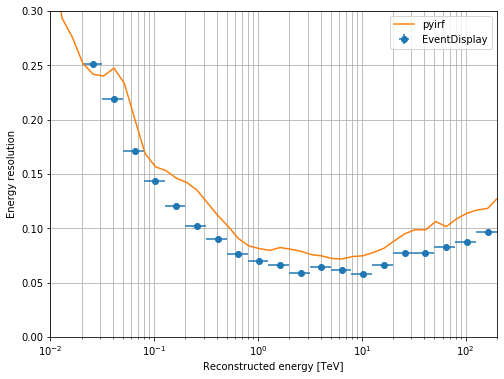

In [14]:
zoom = 2
plt.figure(figsize=(zoom*4,zoom*3))

# Data from EventDisplay
h = input_EventDisplay["ERes"]
x = np.asarray([(10**x_bin[1]+10**x_bin[0])/2. for x_bin in h.bins[1:]])
xerr = np.asarray([(10**x_bin[1]-10**x_bin[0])/2 for x_bin in h.bins[1:]])
y = h.values[1:]
yerr = h.variances[1:]

# Style settings
plt.xlim(1.e-2, 2.e2)
plt.ylim(0., 0.3)
plt.xscale("log")
#plt.yscale("log")
plt.xlabel("Reconstructed energy [TeV]")
plt.ylabel("Energy resolution")
plt.grid(which="both")

# Plot function
plt.errorbar(x, y, xerr=xerr, yerr=yerr, fmt="o", label="EventDisplay")
plt.semilogx(edisp_true_pyirf, resolution_pyirf, label="pyirf")

plt.legend(loc="best")
plt.show()

#### Background rate
[back to top](#Table-of-contents)

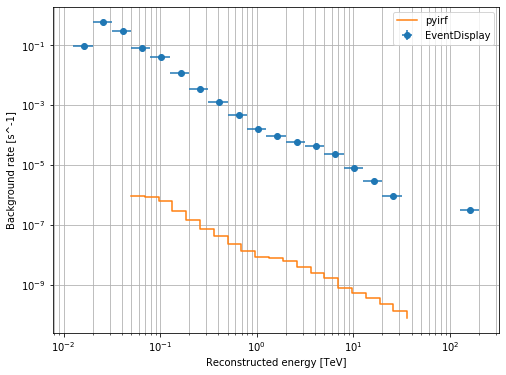

In [16]:
zoom = 2
plt.figure(figsize=(zoom*4,zoom*3))

# Data from EventDisplay
h = input_EventDisplay["BGRate"]
x = np.asarray([(10**x_bin[1]+10**x_bin[0])/2. for x_bin in h.bins])
xerr = np.asarray([(10**x_bin[1]-10**x_bin[0])/2 for x_bin in h.bins])
y = h.values
yerr = h.variances

# Style settings
#plt.xlim(1.e-2, 2.e2)
#plt.ylim(1.e-7, 1.1)
plt.xscale("log")
plt.xlabel("Reconstructed energy [TeV]")
plt.ylabel("Background rate [s^-1]")
plt.grid(which="both")

# Plot function
plt.errorbar(x, y, xerr=xerr, yerr=yerr, fmt="o", label="EventDisplay")
plt.loglog(background_pyirf.columns['ENERG_LO'].array,
           background_pyirf.columns['BGD'].array,
           drawstyle='steps-post',
           label="pyirf")

plt.legend(loc="best")
plt.show()

### Differential sensitivity
[back to top](#Table-of-contents)

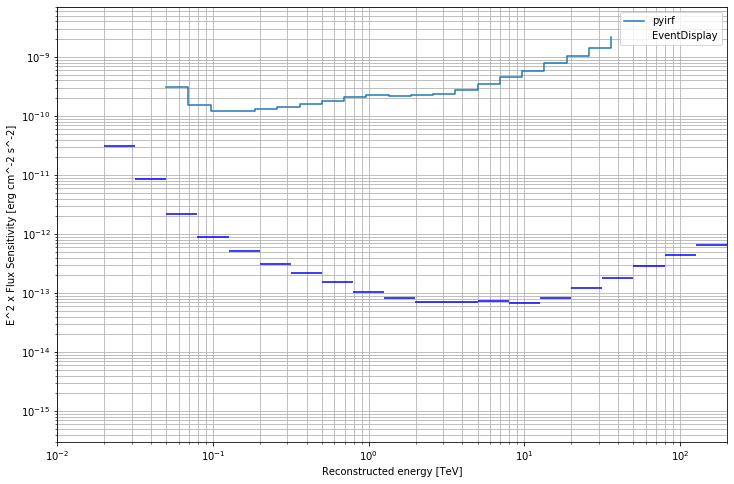

In [18]:
plt.figure(figsize=(12,8))

# Data
h = input_EventDisplay["DiffSens"]

#x = np.asarray([(x_bin[1]+x_bin[0])/2. for x_bin in h.allbins[2:-1]])
x = 10**h.edges[1:-1]

y = h.values[1:]
#yerr = h.allvariances[2:-1]

# Style settings
plt.xlim(1.e-2, 2.e2)
plt.ylim(3.e-16, 7.e-9)

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Reconstructed energy [TeV]")
plt.ylabel("E^2 x Flux Sensitivity [erg cm^-2 s^-2]")
plt.grid(which="both")


# Plot function

errdict=dict(fmt="o")

plt.bar(x,
        height=y, 
        width=np.diff(10**h.edges[1:]), 
        align='edge', 
        xerr=np.diff(10**h.edges[1:])/2,
        yerr=None,
        fill=False,
        linewidth=0,
        label="EventDisplay",
        ecolor = "blue",
        )

plt.loglog(sensitivity_pyirf.columns['ENERG_LO'].array,
           sensitivity_pyirf.columns['SENSITIVITY'].array,
           drawstyle='steps-post',
           label="pyirf")

plt.legend(loc="best")
plt.show()

## Close FITS files

In [19]:
input_EventDisplay.close()
hdul_pyirf.close()